In [1]:
#basic modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pickle
import warnings 
warnings.filterwarnings('ignore')

#sklearn modules
#data preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

#model creation
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier 

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

#model evaluation
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay,f1_score,recall_score,accuracy_score



In [2]:
encoder=LabelEncoder()

# connecting to database

In [3]:
!pip install mysql-connector-python


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import mysql.connector

In [5]:
connection = mysql.connector.connect(
    host="18.136.157.135",
    user="dm_team",
    password="DM!$Team@&27920!",
    database="project_itsm"
)

In [6]:
#basic checks

In [7]:
query = 'select * from dataset_list'
df=pd.read_sql(query,connection)

In [8]:
df=df.replace('',pd.NA)

In [9]:
pd.set_option('display.max_columns',None)

In [10]:
df.head()

,CI_Name,CI_Cat,CI_Subcat,WBS,Incident_ID,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,Alert_Status,No_of_Reassignments,Open_Time,Reopen_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction,No_of_Related_Incidents,No_of_Related_Changes,Related_Change
0,SUB000508,subapplication,Web Based Application,WBS000162,IM0000004,Closed,4,4,4,0.601292279,incident,KM0000553,closed,26,05-02-2012 13:32,<NA>,04-11-2013 13:50,04-11-2013 13:51,"3,87,16,91,111",Other,1,SD0000007,2,<NA>,<NA>
1,WBA000124,application,Web Based Application,WBS000088,IM0000005,Closed,3,3,3,0.415049969,incident,KM0000611,closed,33,12-03-2012 15:44,02-12-2013 12:31,02-12-2013 12:36,02-12-2013 12:36,"4,35,47,86,389",Software,1,SD0000011,1,<NA>,<NA>
2,DTA000024,application,Desktop Application,WBS000092,IM0000006,Closed,NS,3,NA,0.517551335,request for information,KM0000339,closed,3,29-03-2012 12:36,<NA>,13-01-2014 15:12,13-01-2014 15:13,"4,84,31,19,444",No error - works as designed,1,SD0000017,<NA>,<NA>,<NA>
3,WBA000124,application,Web Based Application,WBS000088,IM0000011,Closed,4,4,4,0.642927218,incident,KM0000611,closed,13,17-07-2012 11:49,<NA>,14-11-2013 09:31,14-11-2013 09:31,"4,32,18,33,333",Operator error,1,SD0000025,<NA>,<NA>,<NA>
4,WBA000124,application,Web Based Application,WBS000088,IM0000012,Closed,4,4,4,0.345258343,incident,KM0000611,closed,2,10-08-2012 11:01,<NA>,08-11-2013 13:55,08-11-2013 13:55,"3,38,39,03,333",Other,1,SD0000029,<NA>,<NA>,<NA>


In [11]:
exclude_columns =['CI_Name','CI_Subcat','WBS','Incident_ID','number_cnt','KB_number','Open_Time','Reopen_Time','Resolved_Time',
      'Close_Time','Handle_Time_hrs','Related_Interaction','No_of_Related_Incidents','No_of_Related_Changes','Related_Change']
print(len([column for column in df.columns if column not in exclude_columns]))
print('\n')
print([column for column in df.columns if column not in exclude_columns])

10


['CI_Cat', 'Status', 'Impact', 'Urgency', 'Priority', 'Category', 'Alert_Status', 'No_of_Reassignments', 'Closure_Code', 'No_of_Related_Interactions']


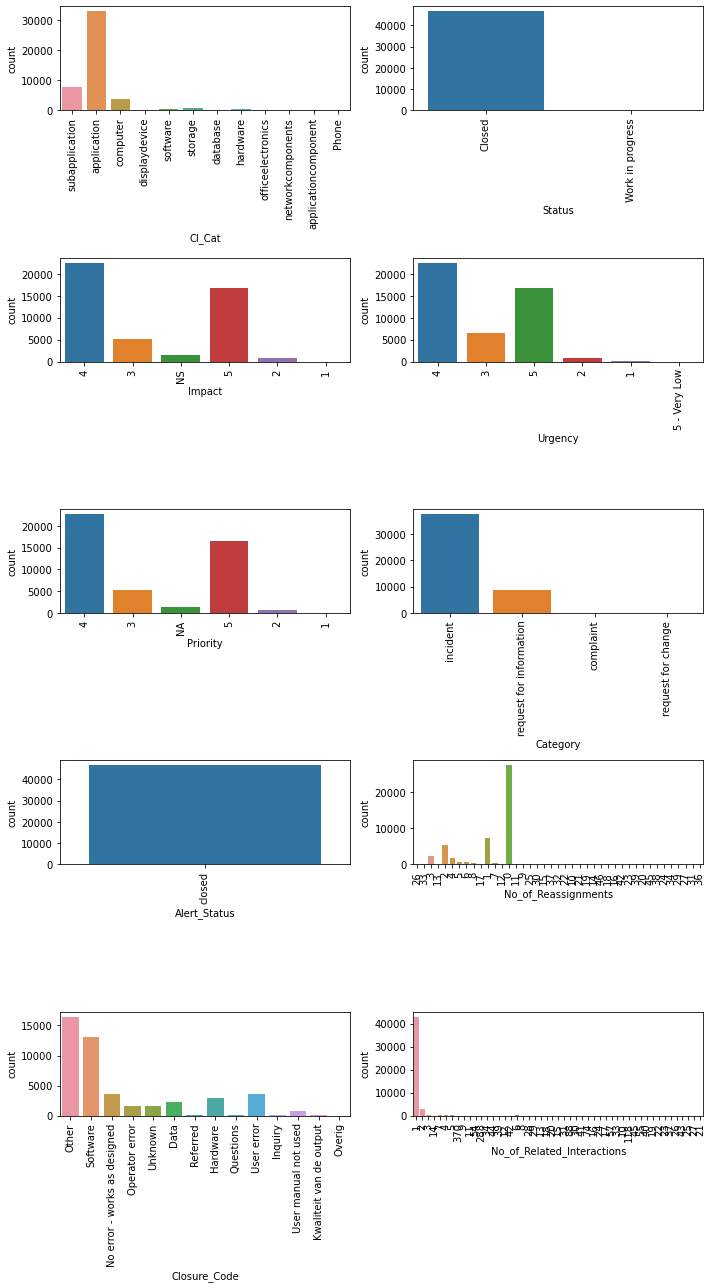

In [12]:
#EDA
pl_no=1
plt.figure(figsize=(10,18))
for i in [column for column in df.columns if column not in exclude_columns]:
    plt.subplot(5,2,pl_no)
    sns.countplot(x=i,data=df)
    plt.xlabel(i)
    plt.xticks(rotation=90)
    pl_no+=1
plt.tight_layout()

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46606 entries, 0 to 46605
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   CI_Name                     46606 non-null  object
 1   CI_Cat                      46495 non-null  object
 2   CI_Subcat                   46495 non-null  object
 3   WBS                         46606 non-null  object
 4   Incident_ID                 46606 non-null  object
 5   Status                      46606 non-null  object
 6   Impact                      46606 non-null  object
 7   Urgency                     46606 non-null  object
 8   Priority                    46606 non-null  object
 9   number_cnt                  46606 non-null  object
 10  Category                    46606 non-null  object
 11  KB_number                   46606 non-null  object
 12  Alert_Status                46606 non-null  object
 13  No_of_Reassignments         46605 non-null  ob

In [14]:
null_df=pd.DataFrame((df.isnull().sum()/len(df))*100,columns=['per'])
null_df['count']=df.isnull().sum()
null_df

,per,count
CI_Name,0.000000,0
CI_Cat,0.238167,111
CI_Subcat,0.238167,111
WBS,0.000000,0
Incident_ID,0.000000,0
Status,0.000000,0
Impact,0.000000,0
Urgency,0.000000,0
Priority,0.000000,0
number_cnt,0.000000,0


In [15]:
null_df[null_df['per']>50]

,per,count
Reopen_Time,95.099343,44322
No_of_Related_Incidents,97.378020,45384
No_of_Related_Changes,98.798438,46046
Related_Change,98.798438,46046


In [16]:
df.drop(null_df[null_df['per']>50].index,axis=1,inplace=True)

In [17]:
for i in df.columns:
    if df[i].dtype=='object':

        print(f'{i} {len(df[i].unique())}')
        print('----'*5)

CI_Name 3019
--------------------
CI_Cat 13
--------------------
CI_Subcat 65
--------------------
WBS 274
--------------------
Incident_ID 46606
--------------------
Status 2
--------------------
Impact 6
--------------------
Urgency 6
--------------------
Priority 6
--------------------
number_cnt 46606
--------------------
Category 4
--------------------
KB_number 1825
--------------------
Alert_Status 1
--------------------
No_of_Reassignments 42
--------------------
Open_Time 34636
--------------------
Resolved_Time 33628
--------------------
Close_Time 34528
--------------------
Handle_Time_hrs 30639
--------------------
Closure_Code 15
--------------------
No_of_Related_Interactions 50
--------------------
Related_Interaction 43060
--------------------


In [18]:
for i in df.columns:
    if df[i].dtype=='object':
        if len(df[i].unique())<66:
            print(f'{i} -----> {df[i].unique()}')
            print('----'*10)

CI_Cat -----> ['subapplication' 'application' 'computer' <NA> 'displaydevice' 'software'
 'storage' 'database' 'hardware' 'officeelectronics' 'networkcomponents'
 'applicationcomponent' 'Phone']
----------------------------------------
CI_Subcat -----> ['Web Based Application' 'Desktop Application' 'Server Based Application'
 'SAP' 'Client Based Application' 'Citrix' 'Standard Application'
 'Windows Server' 'Laptop' 'Linux Server' <NA> 'Monitor'
 'Automation Software' 'SAN' 'Banking Device' 'Desktop' 'Database'
 'Oracle Server' 'Keyboard' 'Printer' 'Exchange' 'System Software' 'VDI'
 'Encryption' 'Omgeving' 'MigratieDummy' 'Scanner' 'Controller'
 'DataCenterEquipment' 'KVM Switches' 'Switch' 'Database Software'
 'Network Component' 'Unix Server' 'Lines' 'ESX Cluster' 'zOS Server'
 'SharePoint Farm' 'NonStop Server' 'Application Server'
 'Security Software' 'Thin Client' 'zOS Cluster' 'Router' 'VMWare'
 'Net Device' 'Neoview Server' 'MQ Queue Manager' 'UPS' 'Number'
 'Iptelephony' 'Wind

In [19]:
df.drop('CI_Name',axis=1,inplace=True)

In [20]:
df.head()

,CI_Cat,CI_Subcat,WBS,Incident_ID,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,Alert_Status,No_of_Reassignments,Open_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction
0,subapplication,Web Based Application,WBS000162,IM0000004,Closed,4,4,4,0.601292279,incident,KM0000553,closed,26,05-02-2012 13:32,04-11-2013 13:50,04-11-2013 13:51,"3,87,16,91,111",Other,1,SD0000007
1,application,Web Based Application,WBS000088,IM0000005,Closed,3,3,3,0.415049969,incident,KM0000611,closed,33,12-03-2012 15:44,02-12-2013 12:36,02-12-2013 12:36,"4,35,47,86,389",Software,1,SD0000011
2,application,Desktop Application,WBS000092,IM0000006,Closed,NS,3,NA,0.517551335,request for information,KM0000339,closed,3,29-03-2012 12:36,13-01-2014 15:12,13-01-2014 15:13,"4,84,31,19,444",No error - works as designed,1,SD0000017
3,application,Web Based Application,WBS000088,IM0000011,Closed,4,4,4,0.642927218,incident,KM0000611,closed,13,17-07-2012 11:49,14-11-2013 09:31,14-11-2013 09:31,"4,32,18,33,333",Operator error,1,SD0000025
4,application,Web Based Application,WBS000088,IM0000012,Closed,4,4,4,0.345258343,incident,KM0000611,closed,2,10-08-2012 11:01,08-11-2013 13:55,08-11-2013 13:55,"3,38,39,03,333",Other,1,SD0000029


In [21]:
#df['Cl_Cat']
df['CI_Cat'].value_counts()

application             32900
subapplication           7782
computer                 3643
storage                   703
hardware                  442
software                  333
database                  214
displaydevice             212
officeelectronics         152
networkcomponents         107
applicationcomponent        5
Phone                       2
Name: CI_Cat, dtype: int64

In [22]:
df['CI_Cat'].isnull().sum()

111

In [23]:
df.loc[df['CI_Cat'].isnull(),'CI_Cat']='application'

In [24]:
df['CI_Cat'].value_counts()

application             33011
subapplication           7782
computer                 3643
storage                   703
hardware                  442
software                  333
database                  214
displaydevice             212
officeelectronics         152
networkcomponents         107
applicationcomponent        5
Phone                       2
Name: CI_Cat, dtype: int64

In [25]:
df['CI_Cat']=encoder.fit_transform(df['CI_Cat'])

In [26]:
df.head()

,CI_Cat,CI_Subcat,WBS,Incident_ID,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,Alert_Status,No_of_Reassignments,Open_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction
0,11,Web Based Application,WBS000162,IM0000004,Closed,4,4,4,0.601292279,incident,KM0000553,closed,26,05-02-2012 13:32,04-11-2013 13:50,04-11-2013 13:51,"3,87,16,91,111",Other,1,SD0000007
1,1,Web Based Application,WBS000088,IM0000005,Closed,3,3,3,0.415049969,incident,KM0000611,closed,33,12-03-2012 15:44,02-12-2013 12:36,02-12-2013 12:36,"4,35,47,86,389",Software,1,SD0000011
2,1,Desktop Application,WBS000092,IM0000006,Closed,NS,3,NA,0.517551335,request for information,KM0000339,closed,3,29-03-2012 12:36,13-01-2014 15:12,13-01-2014 15:13,"4,84,31,19,444",No error - works as designed,1,SD0000017
3,1,Web Based Application,WBS000088,IM0000011,Closed,4,4,4,0.642927218,incident,KM0000611,closed,13,17-07-2012 11:49,14-11-2013 09:31,14-11-2013 09:31,"4,32,18,33,333",Operator error,1,SD0000025
4,1,Web Based Application,WBS000088,IM0000012,Closed,4,4,4,0.345258343,incident,KM0000611,closed,2,10-08-2012 11:01,08-11-2013 13:55,08-11-2013 13:55,"3,38,39,03,333",Other,1,SD0000029


In [27]:
#df['Cl_Subcat']
df['CI_Subcat'].unique()

array(['Web Based Application', 'Desktop Application',
       'Server Based Application', 'SAP', 'Client Based Application',
       'Citrix', 'Standard Application', 'Windows Server', 'Laptop',
       'Linux Server', <NA>, 'Monitor', 'Automation Software', 'SAN',
       'Banking Device', 'Desktop', 'Database', 'Oracle Server',
       'Keyboard', 'Printer', 'Exchange', 'System Software', 'VDI',
       'Encryption', 'Omgeving', 'MigratieDummy', 'Scanner', 'Controller',
       'DataCenterEquipment', 'KVM Switches', 'Switch',
       'Database Software', 'Network Component', 'Unix Server', 'Lines',
       'ESX Cluster', 'zOS Server', 'SharePoint Farm', 'NonStop Server',
       'Application Server', 'Security Software', 'Thin Client',
       'zOS Cluster', 'Router', 'VMWare', 'Net Device', 'Neoview Server',
       'MQ Queue Manager', 'UPS', 'Number', 'Iptelephony',
       'Windows Server in extern beheer', 'Modem', 'X86 Server',
       'ESX Server', 'Virtual Tape Server', 'IPtelephony',
    

In [28]:
df['CI_Subcat'].isnull().sum()

111

In [29]:
df['CI_Subcat'].mode()

0    Server Based Application
Name: CI_Subcat, dtype: object

In [30]:
df.loc[df['CI_Subcat'].isnull(),'CI_Subcat']=df['CI_Subcat'].mode()[0]

In [31]:
df['CI_Subcat'].isnull().sum()

0

In [32]:
df['CI_Subcat']=encoder.fit_transform(df['CI_Subcat'])

In [33]:
df.head()

,CI_Cat,CI_Subcat,WBS,Incident_ID,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,Alert_Status,No_of_Reassignments,Open_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction
0,11,57,WBS000162,IM0000004,Closed,4,4,4,0.601292279,incident,KM0000553,closed,26,05-02-2012 13:32,04-11-2013 13:50,04-11-2013 13:51,"3,87,16,91,111",Other,1,SD0000007
1,1,57,WBS000088,IM0000005,Closed,3,3,3,0.415049969,incident,KM0000611,closed,33,12-03-2012 15:44,02-12-2013 12:36,02-12-2013 12:36,"4,35,47,86,389",Software,1,SD0000011
2,1,10,WBS000092,IM0000006,Closed,NS,3,NA,0.517551335,request for information,KM0000339,closed,3,29-03-2012 12:36,13-01-2014 15:12,13-01-2014 15:13,"4,84,31,19,444",No error - works as designed,1,SD0000017
3,1,57,WBS000088,IM0000011,Closed,4,4,4,0.642927218,incident,KM0000611,closed,13,17-07-2012 11:49,14-11-2013 09:31,14-11-2013 09:31,"4,32,18,33,333",Operator error,1,SD0000025
4,1,57,WBS000088,IM0000012,Closed,4,4,4,0.345258343,incident,KM0000611,closed,2,10-08-2012 11:01,08-11-2013 13:55,08-11-2013 13:55,"3,38,39,03,333",Other,1,SD0000029


In [34]:
#df['WBS']
len(df['WBS'].unique())

274

In [35]:
df['WBS']=df['WBS'].apply(lambda x: x[-3:])

In [36]:
df['WBS']

0        162
1        088
2        092
3        088
4        088
        ... 
46601    073
46602    073
46603    091
46604    073
46605    267
Name: WBS, Length: 46606, dtype: object

In [37]:
df['WBS']=df['WBS'].astype(int)

In [38]:
df.head()

,CI_Cat,CI_Subcat,WBS,Incident_ID,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,Alert_Status,No_of_Reassignments,Open_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction
0,11,57,162,IM0000004,Closed,4,4,4,0.601292279,incident,KM0000553,closed,26,05-02-2012 13:32,04-11-2013 13:50,04-11-2013 13:51,"3,87,16,91,111",Other,1,SD0000007
1,1,57,88,IM0000005,Closed,3,3,3,0.415049969,incident,KM0000611,closed,33,12-03-2012 15:44,02-12-2013 12:36,02-12-2013 12:36,"4,35,47,86,389",Software,1,SD0000011
2,1,10,92,IM0000006,Closed,NS,3,NA,0.517551335,request for information,KM0000339,closed,3,29-03-2012 12:36,13-01-2014 15:12,13-01-2014 15:13,"4,84,31,19,444",No error - works as designed,1,SD0000017
3,1,57,88,IM0000011,Closed,4,4,4,0.642927218,incident,KM0000611,closed,13,17-07-2012 11:49,14-11-2013 09:31,14-11-2013 09:31,"4,32,18,33,333",Operator error,1,SD0000025
4,1,57,88,IM0000012,Closed,4,4,4,0.345258343,incident,KM0000611,closed,2,10-08-2012 11:01,08-11-2013 13:55,08-11-2013 13:55,"3,38,39,03,333",Other,1,SD0000029


In [39]:
#df['Incident_ID']
len(df['Incident_ID'].unique())

46606

In [40]:
df.drop('Incident_ID',axis=1,inplace=True)

In [41]:
df.head()

,CI_Cat,CI_Subcat,WBS,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,Alert_Status,No_of_Reassignments,Open_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction
0,11,57,162,Closed,4,4,4,0.601292279,incident,KM0000553,closed,26,05-02-2012 13:32,04-11-2013 13:50,04-11-2013 13:51,"3,87,16,91,111",Other,1,SD0000007
1,1,57,88,Closed,3,3,3,0.415049969,incident,KM0000611,closed,33,12-03-2012 15:44,02-12-2013 12:36,02-12-2013 12:36,"4,35,47,86,389",Software,1,SD0000011
2,1,10,92,Closed,NS,3,NA,0.517551335,request for information,KM0000339,closed,3,29-03-2012 12:36,13-01-2014 15:12,13-01-2014 15:13,"4,84,31,19,444",No error - works as designed,1,SD0000017
3,1,57,88,Closed,4,4,4,0.642927218,incident,KM0000611,closed,13,17-07-2012 11:49,14-11-2013 09:31,14-11-2013 09:31,"4,32,18,33,333",Operator error,1,SD0000025
4,1,57,88,Closed,4,4,4,0.345258343,incident,KM0000611,closed,2,10-08-2012 11:01,08-11-2013 13:55,08-11-2013 13:55,"3,38,39,03,333",Other,1,SD0000029


In [42]:
#df['Status']
df['Status'].unique()

array(['Closed', 'Work in progress'], dtype=object)

In [43]:
df['Status'].isnull().sum()

0

In [44]:
df['Status']=encoder.fit_transform(df['Status'])

In [45]:
df.head()

,CI_Cat,CI_Subcat,WBS,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,Alert_Status,No_of_Reassignments,Open_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction
0,11,57,162,0,4,4,4,0.601292279,incident,KM0000553,closed,26,05-02-2012 13:32,04-11-2013 13:50,04-11-2013 13:51,"3,87,16,91,111",Other,1,SD0000007
1,1,57,88,0,3,3,3,0.415049969,incident,KM0000611,closed,33,12-03-2012 15:44,02-12-2013 12:36,02-12-2013 12:36,"4,35,47,86,389",Software,1,SD0000011
2,1,10,92,0,NS,3,NA,0.517551335,request for information,KM0000339,closed,3,29-03-2012 12:36,13-01-2014 15:12,13-01-2014 15:13,"4,84,31,19,444",No error - works as designed,1,SD0000017
3,1,57,88,0,4,4,4,0.642927218,incident,KM0000611,closed,13,17-07-2012 11:49,14-11-2013 09:31,14-11-2013 09:31,"4,32,18,33,333",Operator error,1,SD0000025
4,1,57,88,0,4,4,4,0.345258343,incident,KM0000611,closed,2,10-08-2012 11:01,08-11-2013 13:55,08-11-2013 13:55,"3,38,39,03,333",Other,1,SD0000029


In [46]:
#df['Impact']
df['Impact'].value_counts()

4     22556
5     16741
3      5234
NS     1380
2       692
1         3
Name: Impact, dtype: int64

In [47]:
df['Impact'].mode()[0]

'4'

In [48]:
#replacing the null values with mode of the column i.e 4
df.loc[df['Impact']=='NS','Impact']=df['Impact'].mode()[0]

In [49]:
df.loc[df['Impact']=='NS']

,CI_Cat,CI_Subcat,WBS,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,Alert_Status,No_of_Reassignments,Open_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction


In [50]:
df['Impact'].dtype

dtype('O')

In [51]:
df['Impact']=df['Impact'].astype(int)

In [52]:
df['Impact'].unique()

array([4, 3, 5, 2, 1])

In [53]:
#df['Urgency']
df['Urgency'].value_counts()

4               22588
5               16779
3                6536
2                 696
1                   6
5 - Very Low        1
Name: Urgency, dtype: int64

In [54]:
df['Urgency'].unique()

array(['4', '3', '5', '2', '1', '5 - Very Low'], dtype=object)

In [55]:
df.shape

(46606, 19)

In [56]:
df.head()

,CI_Cat,CI_Subcat,WBS,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,Alert_Status,No_of_Reassignments,Open_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction
0,11,57,162,0,4,4,4,0.601292279,incident,KM0000553,closed,26,05-02-2012 13:32,04-11-2013 13:50,04-11-2013 13:51,"3,87,16,91,111",Other,1,SD0000007
1,1,57,88,0,3,3,3,0.415049969,incident,KM0000611,closed,33,12-03-2012 15:44,02-12-2013 12:36,02-12-2013 12:36,"4,35,47,86,389",Software,1,SD0000011
2,1,10,92,0,4,3,NA,0.517551335,request for information,KM0000339,closed,3,29-03-2012 12:36,13-01-2014 15:12,13-01-2014 15:13,"4,84,31,19,444",No error - works as designed,1,SD0000017
3,1,57,88,0,4,4,4,0.642927218,incident,KM0000611,closed,13,17-07-2012 11:49,14-11-2013 09:31,14-11-2013 09:31,"4,32,18,33,333",Operator error,1,SD0000025
4,1,57,88,0,4,4,4,0.345258343,incident,KM0000611,closed,2,10-08-2012 11:01,08-11-2013 13:55,08-11-2013 13:55,"3,38,39,03,333",Other,1,SD0000029


In [57]:
#df['Priorityy']
df['Priority'].unique()

array(['4', '3', 'NA', '5', '2', '1'], dtype=object)

In [58]:
df['Priority'].value_counts()

4     22717
5     16486
3      5323
NA     1380
2       697
1         3
Name: Priority, dtype: int64

In [59]:
#replacing the null values with mode
df['Priority'].mode()

0    4
Name: Priority, dtype: object

In [60]:
df.loc[df['Priority']=='NA','Priority']=df['Priority'].mode()[0]

In [61]:
df['Priority']=df['Priority'].astype(int)

In [62]:
df.head()

,CI_Cat,CI_Subcat,WBS,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,Alert_Status,No_of_Reassignments,Open_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction
0,11,57,162,0,4,4,4,0.601292279,incident,KM0000553,closed,26,05-02-2012 13:32,04-11-2013 13:50,04-11-2013 13:51,"3,87,16,91,111",Other,1,SD0000007
1,1,57,88,0,3,3,3,0.415049969,incident,KM0000611,closed,33,12-03-2012 15:44,02-12-2013 12:36,02-12-2013 12:36,"4,35,47,86,389",Software,1,SD0000011
2,1,10,92,0,4,3,4,0.517551335,request for information,KM0000339,closed,3,29-03-2012 12:36,13-01-2014 15:12,13-01-2014 15:13,"4,84,31,19,444",No error - works as designed,1,SD0000017
3,1,57,88,0,4,4,4,0.642927218,incident,KM0000611,closed,13,17-07-2012 11:49,14-11-2013 09:31,14-11-2013 09:31,"4,32,18,33,333",Operator error,1,SD0000025
4,1,57,88,0,4,4,4,0.345258343,incident,KM0000611,closed,2,10-08-2012 11:01,08-11-2013 13:55,08-11-2013 13:55,"3,38,39,03,333",Other,1,SD0000029


In [63]:
#df['number_cnt']
df['number_cnt']=df['number_cnt'].astype(float)

In [64]:
#df['Category']
df['Category'].unique()

array(['incident', 'request for information', 'complaint',
       'request for change'], dtype=object)

In [65]:
#transforming the catergorical columns to numerical columns

In [66]:
df['Category']=encoder.fit_transform(df['Category'])

In [67]:
df.head()

,CI_Cat,CI_Subcat,WBS,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,Alert_Status,No_of_Reassignments,Open_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction
0,11,57,162,0,4,4,4,0.601292,1,KM0000553,closed,26,05-02-2012 13:32,04-11-2013 13:50,04-11-2013 13:51,"3,87,16,91,111",Other,1,SD0000007
1,1,57,88,0,3,3,3,0.415050,1,KM0000611,closed,33,12-03-2012 15:44,02-12-2013 12:36,02-12-2013 12:36,"4,35,47,86,389",Software,1,SD0000011
2,1,10,92,0,4,3,4,0.517551,3,KM0000339,closed,3,29-03-2012 12:36,13-01-2014 15:12,13-01-2014 15:13,"4,84,31,19,444",No error - works as designed,1,SD0000017
3,1,57,88,0,4,4,4,0.642927,1,KM0000611,closed,13,17-07-2012 11:49,14-11-2013 09:31,14-11-2013 09:31,"4,32,18,33,333",Operator error,1,SD0000025
4,1,57,88,0,4,4,4,0.345258,1,KM0000611,closed,2,10-08-2012 11:01,08-11-2013 13:55,08-11-2013 13:55,"3,38,39,03,333",Other,1,SD0000029


In [68]:
#df['Alert_Status']

In [69]:
df['Alert_Status'].unique()

array(['closed'], dtype=object)

In [70]:
df['Alert_Status'].value_counts()

closed    46606
Name: Alert_Status, dtype: int64

In [71]:
#as almost all the columns are in closed state dropping the columns

In [72]:
df.drop('Alert_Status',axis=1,inplace=True)

In [73]:
df.head()

,CI_Cat,CI_Subcat,WBS,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,No_of_Reassignments,Open_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction
0,11,57,162,0,4,4,4,0.601292,1,KM0000553,26,05-02-2012 13:32,04-11-2013 13:50,04-11-2013 13:51,"3,87,16,91,111",Other,1,SD0000007
1,1,57,88,0,3,3,3,0.415050,1,KM0000611,33,12-03-2012 15:44,02-12-2013 12:36,02-12-2013 12:36,"4,35,47,86,389",Software,1,SD0000011
2,1,10,92,0,4,3,4,0.517551,3,KM0000339,3,29-03-2012 12:36,13-01-2014 15:12,13-01-2014 15:13,"4,84,31,19,444",No error - works as designed,1,SD0000017
3,1,57,88,0,4,4,4,0.642927,1,KM0000611,13,17-07-2012 11:49,14-11-2013 09:31,14-11-2013 09:31,"4,32,18,33,333",Operator error,1,SD0000025
4,1,57,88,0,4,4,4,0.345258,1,KM0000611,2,10-08-2012 11:01,08-11-2013 13:55,08-11-2013 13:55,"3,38,39,03,333",Other,1,SD0000029


In [74]:
#df['KB_number']

In [75]:
len(df['KB_number'].unique())

1825

In [76]:
#df['no_of_Reassignments']


In [77]:
len(df['No_of_Reassignments'].unique())

42

In [78]:
df['No_of_Reassignments'].mode()

0    0
Name: No_of_Reassignments, dtype: object

In [79]:
df['No_of_Reassignments'].isnull().sum()

1

In [80]:
df.loc[df['No_of_Reassignments'].isnull(),'No_of_Reassignments']=df['No_of_Reassignments'].mode()[0]

In [81]:
df['No_of_Reassignments'].isnull().sum()

0

In [82]:
df['No_of_Reassignments']=df['No_of_Reassignments'].astype(int)

In [83]:
df.head()

,CI_Cat,CI_Subcat,WBS,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,No_of_Reassignments,Open_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction
0,11,57,162,0,4,4,4,0.601292,1,KM0000553,26,05-02-2012 13:32,04-11-2013 13:50,04-11-2013 13:51,"3,87,16,91,111",Other,1,SD0000007
1,1,57,88,0,3,3,3,0.415050,1,KM0000611,33,12-03-2012 15:44,02-12-2013 12:36,02-12-2013 12:36,"4,35,47,86,389",Software,1,SD0000011
2,1,10,92,0,4,3,4,0.517551,3,KM0000339,3,29-03-2012 12:36,13-01-2014 15:12,13-01-2014 15:13,"4,84,31,19,444",No error - works as designed,1,SD0000017
3,1,57,88,0,4,4,4,0.642927,1,KM0000611,13,17-07-2012 11:49,14-11-2013 09:31,14-11-2013 09:31,"4,32,18,33,333",Operator error,1,SD0000025
4,1,57,88,0,4,4,4,0.345258,1,KM0000611,2,10-08-2012 11:01,08-11-2013 13:55,08-11-2013 13:55,"3,38,39,03,333",Other,1,SD0000029


In [84]:
#df['OPEN_tIME']

In [85]:
df['Open_Time'].isnull().sum()

0

In [86]:
#converting the open time column to datetime format
df['Open_Time']=pd.to_datetime(df['Open_Time'])

In [87]:
df.head()

,CI_Cat,CI_Subcat,WBS,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,No_of_Reassignments,Open_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction
0,11,57,162,0,4,4,4,0.601292,1,KM0000553,26,2012-05-02 13:32:00,04-11-2013 13:50,04-11-2013 13:51,"3,87,16,91,111",Other,1,SD0000007
1,1,57,88,0,3,3,3,0.415050,1,KM0000611,33,2012-12-03 15:44:00,02-12-2013 12:36,02-12-2013 12:36,"4,35,47,86,389",Software,1,SD0000011
2,1,10,92,0,4,3,4,0.517551,3,KM0000339,3,2012-03-29 12:36:00,13-01-2014 15:12,13-01-2014 15:13,"4,84,31,19,444",No error - works as designed,1,SD0000017
3,1,57,88,0,4,4,4,0.642927,1,KM0000611,13,2012-07-17 11:49:00,14-11-2013 09:31,14-11-2013 09:31,"4,32,18,33,333",Operator error,1,SD0000025
4,1,57,88,0,4,4,4,0.345258,1,KM0000611,2,2012-10-08 11:01:00,08-11-2013 13:55,08-11-2013 13:55,"3,38,39,03,333",Other,1,SD0000029


In [88]:
#df['Resolved_time']
df['Resolved_Time']=pd.to_datetime(df['Resolved_Time'])

In [89]:
df.head()

,CI_Cat,CI_Subcat,WBS,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,No_of_Reassignments,Open_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction
0,11,57,162,0,4,4,4,0.601292,1,KM0000553,26,2012-05-02 13:32:00,2013-04-11 13:50:00,04-11-2013 13:51,"3,87,16,91,111",Other,1,SD0000007
1,1,57,88,0,3,3,3,0.415050,1,KM0000611,33,2012-12-03 15:44:00,2013-02-12 12:36:00,02-12-2013 12:36,"4,35,47,86,389",Software,1,SD0000011
2,1,10,92,0,4,3,4,0.517551,3,KM0000339,3,2012-03-29 12:36:00,2014-01-13 15:12:00,13-01-2014 15:13,"4,84,31,19,444",No error - works as designed,1,SD0000017
3,1,57,88,0,4,4,4,0.642927,1,KM0000611,13,2012-07-17 11:49:00,2013-11-14 09:31:00,14-11-2013 09:31,"4,32,18,33,333",Operator error,1,SD0000025
4,1,57,88,0,4,4,4,0.345258,1,KM0000611,2,2012-10-08 11:01:00,2013-08-11 13:55:00,08-11-2013 13:55,"3,38,39,03,333",Other,1,SD0000029


In [90]:
df['Resolved_Time'].isnull().sum()

1780

In [91]:
df['Resolved_Time'].mode()[0]

Timestamp('2013-10-10 12:53:00')

In [92]:
df.loc[df['Resolved_Time'].isnull(),'Resolved_Time']=df['Resolved_Time'].mode()[0]

In [93]:
df['Resolved_Time'].isnull().sum()

0

In [94]:
df['Resolved_Time']=pd.to_datetime(df['Resolved_Time'])

In [95]:
df.head()

,CI_Cat,CI_Subcat,WBS,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,No_of_Reassignments,Open_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction
0,11,57,162,0,4,4,4,0.601292,1,KM0000553,26,2012-05-02 13:32:00,2013-04-11 13:50:00,04-11-2013 13:51,"3,87,16,91,111",Other,1,SD0000007
1,1,57,88,0,3,3,3,0.415050,1,KM0000611,33,2012-12-03 15:44:00,2013-02-12 12:36:00,02-12-2013 12:36,"4,35,47,86,389",Software,1,SD0000011
2,1,10,92,0,4,3,4,0.517551,3,KM0000339,3,2012-03-29 12:36:00,2014-01-13 15:12:00,13-01-2014 15:13,"4,84,31,19,444",No error - works as designed,1,SD0000017
3,1,57,88,0,4,4,4,0.642927,1,KM0000611,13,2012-07-17 11:49:00,2013-11-14 09:31:00,14-11-2013 09:31,"4,32,18,33,333",Operator error,1,SD0000025
4,1,57,88,0,4,4,4,0.345258,1,KM0000611,2,2012-10-08 11:01:00,2013-08-11 13:55:00,08-11-2013 13:55,"3,38,39,03,333",Other,1,SD0000029


In [96]:
#df['close_Time']
df['Close_Time'].isnull().sum()

0

In [97]:
df['Close_Time']=pd.to_datetime(df['Close_Time'])

In [98]:
df.head()

,CI_Cat,CI_Subcat,WBS,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,No_of_Reassignments,Open_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction
0,11,57,162,0,4,4,4,0.601292,1,KM0000553,26,2012-05-02 13:32:00,2013-04-11 13:50:00,2013-04-11 13:51:00,"3,87,16,91,111",Other,1,SD0000007
1,1,57,88,0,3,3,3,0.415050,1,KM0000611,33,2012-12-03 15:44:00,2013-02-12 12:36:00,2013-02-12 12:36:00,"4,35,47,86,389",Software,1,SD0000011
2,1,10,92,0,4,3,4,0.517551,3,KM0000339,3,2012-03-29 12:36:00,2014-01-13 15:12:00,2014-01-13 15:13:00,"4,84,31,19,444",No error - works as designed,1,SD0000017
3,1,57,88,0,4,4,4,0.642927,1,KM0000611,13,2012-07-17 11:49:00,2013-11-14 09:31:00,2013-11-14 09:31:00,"4,32,18,33,333",Operator error,1,SD0000025
4,1,57,88,0,4,4,4,0.345258,1,KM0000611,2,2012-10-08 11:01:00,2013-08-11 13:55:00,2013-08-11 13:55:00,"3,38,39,03,333",Other,1,SD0000029


In [99]:
#df['Handle_Time_hrs']
#converting the difference days to hours taken

In [100]:
df.drop('Handle_Time_hrs',axis=1,inplace=True)

In [101]:
df['Handle_Time_hrs_conv']=abs(df['Close_Time']-df['Open_Time'])

In [102]:
a=[]
for i in df['Handle_Time_hrs_conv'].index:
    a.append((df['Handle_Time_hrs_conv'][i].total_seconds())/3600)



In [103]:
df['Handle_Time_hrs_conv']=a

In [104]:
df.head()

,CI_Cat,CI_Subcat,WBS,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,No_of_Reassignments,Open_Time,Resolved_Time,Close_Time,Closure_Code,No_of_Related_Interactions,Related_Interaction,Handle_Time_hrs_conv
0,11,57,162,0,4,4,4,0.601292,1,KM0000553,26,2012-05-02 13:32:00,2013-04-11 13:50:00,2013-04-11 13:51:00,Other,1,SD0000007,8256.316667
1,1,57,88,0,3,3,3,0.415050,1,KM0000611,33,2012-12-03 15:44:00,2013-02-12 12:36:00,2013-02-12 12:36:00,Software,1,SD0000011,1700.866667
2,1,10,92,0,4,3,4,0.517551,3,KM0000339,3,2012-03-29 12:36:00,2014-01-13 15:12:00,2014-01-13 15:13:00,No error - works as designed,1,SD0000017,15722.616667
3,1,57,88,0,4,4,4,0.642927,1,KM0000611,13,2012-07-17 11:49:00,2013-11-14 09:31:00,2013-11-14 09:31:00,Operator error,1,SD0000025,11637.700000
4,1,57,88,0,4,4,4,0.345258,1,KM0000611,2,2012-10-08 11:01:00,2013-08-11 13:55:00,2013-08-11 13:55:00,Other,1,SD0000029,7370.900000


In [105]:
#df['closure_code']
df.drop('Closure_Code',axis=1,inplace=True)

In [106]:
df.head()

,CI_Cat,CI_Subcat,WBS,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,No_of_Reassignments,Open_Time,Resolved_Time,Close_Time,No_of_Related_Interactions,Related_Interaction,Handle_Time_hrs_conv
0,11,57,162,0,4,4,4,0.601292,1,KM0000553,26,2012-05-02 13:32:00,2013-04-11 13:50:00,2013-04-11 13:51:00,1,SD0000007,8256.316667
1,1,57,88,0,3,3,3,0.415050,1,KM0000611,33,2012-12-03 15:44:00,2013-02-12 12:36:00,2013-02-12 12:36:00,1,SD0000011,1700.866667
2,1,10,92,0,4,3,4,0.517551,3,KM0000339,3,2012-03-29 12:36:00,2014-01-13 15:12:00,2014-01-13 15:13:00,1,SD0000017,15722.616667
3,1,57,88,0,4,4,4,0.642927,1,KM0000611,13,2012-07-17 11:49:00,2013-11-14 09:31:00,2013-11-14 09:31:00,1,SD0000025,11637.700000
4,1,57,88,0,4,4,4,0.345258,1,KM0000611,2,2012-10-08 11:01:00,2013-08-11 13:55:00,2013-08-11 13:55:00,1,SD0000029,7370.900000


In [107]:
#df['No_of_RElated_interactions']
df['No_of_Related_Interactions'].isnull().sum()

114

In [108]:
len(df['No_of_Related_Interactions'].unique())

50

In [109]:
df['No_of_Related_Interactions'].mode()

0    1
Name: No_of_Related_Interactions, dtype: object

In [110]:
#replacing the null values with mode


In [111]:
df.loc[df['No_of_Related_Interactions'].isnull(),'No_of_Related_Interactions']=df['No_of_Related_Interactions'].mode()[0]

In [112]:




df['No_of_Related_Interactions'].isnull().sum()

0

In [113]:
df['No_of_Related_Interactions']=df['No_of_Related_Interactions'].astype(int)

In [114]:
df.head()

,CI_Cat,CI_Subcat,WBS,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,No_of_Reassignments,Open_Time,Resolved_Time,Close_Time,No_of_Related_Interactions,Related_Interaction,Handle_Time_hrs_conv
0,11,57,162,0,4,4,4,0.601292,1,KM0000553,26,2012-05-02 13:32:00,2013-04-11 13:50:00,2013-04-11 13:51:00,1,SD0000007,8256.316667
1,1,57,88,0,3,3,3,0.415050,1,KM0000611,33,2012-12-03 15:44:00,2013-02-12 12:36:00,2013-02-12 12:36:00,1,SD0000011,1700.866667
2,1,10,92,0,4,3,4,0.517551,3,KM0000339,3,2012-03-29 12:36:00,2014-01-13 15:12:00,2014-01-13 15:13:00,1,SD0000017,15722.616667
3,1,57,88,0,4,4,4,0.642927,1,KM0000611,13,2012-07-17 11:49:00,2013-11-14 09:31:00,2013-11-14 09:31:00,1,SD0000025,11637.700000
4,1,57,88,0,4,4,4,0.345258,1,KM0000611,2,2012-10-08 11:01:00,2013-08-11 13:55:00,2013-08-11 13:55:00,1,SD0000029,7370.900000


In [115]:
#df['Related_Interaction']
len(df['Related_Interaction'].unique())

43060

In [116]:

df.drop('Related_Interaction',axis=1,inplace=True)

In [117]:
#df['KB_number']
len(df['KB_number'].unique())

1825

In [118]:
df['KB_number']=df['KB_number'].apply(lambda x: x[-4:])

In [119]:
df['KB_number']=df['KB_number'].astype(int)

In [120]:
df.head()

,CI_Cat,CI_Subcat,WBS,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,No_of_Reassignments,Open_Time,Resolved_Time,Close_Time,No_of_Related_Interactions,Handle_Time_hrs_conv
0,11,57,162,0,4,4,4,0.601292,1,553,26,2012-05-02 13:32:00,2013-04-11 13:50:00,2013-04-11 13:51:00,1,8256.316667
1,1,57,88,0,3,3,3,0.415050,1,611,33,2012-12-03 15:44:00,2013-02-12 12:36:00,2013-02-12 12:36:00,1,1700.866667
2,1,10,92,0,4,3,4,0.517551,3,339,3,2012-03-29 12:36:00,2014-01-13 15:12:00,2014-01-13 15:13:00,1,15722.616667
3,1,57,88,0,4,4,4,0.642927,1,611,13,2012-07-17 11:49:00,2013-11-14 09:31:00,2013-11-14 09:31:00,1,11637.700000
4,1,57,88,0,4,4,4,0.345258,1,611,2,2012-10-08 11:01:00,2013-08-11 13:55:00,2013-08-11 13:55:00,1,7370.900000


# Preprocessed dataset for machine learning

In [121]:
df.head()

,CI_Cat,CI_Subcat,WBS,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,No_of_Reassignments,Open_Time,Resolved_Time,Close_Time,No_of_Related_Interactions,Handle_Time_hrs_conv
0,11,57,162,0,4,4,4,0.601292,1,553,26,2012-05-02 13:32:00,2013-04-11 13:50:00,2013-04-11 13:51:00,1,8256.316667
1,1,57,88,0,3,3,3,0.415050,1,611,33,2012-12-03 15:44:00,2013-02-12 12:36:00,2013-02-12 12:36:00,1,1700.866667
2,1,10,92,0,4,3,4,0.517551,3,339,3,2012-03-29 12:36:00,2014-01-13 15:12:00,2014-01-13 15:13:00,1,15722.616667
3,1,57,88,0,4,4,4,0.642927,1,611,13,2012-07-17 11:49:00,2013-11-14 09:31:00,2013-11-14 09:31:00,1,11637.700000
4,1,57,88,0,4,4,4,0.345258,1,611,2,2012-10-08 11:01:00,2013-08-11 13:55:00,2013-08-11 13:55:00,1,7370.900000


In [122]:
df.shape

(46606, 16)

In [123]:
data=df.copy()

In [124]:
data.head()

,CI_Cat,CI_Subcat,WBS,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,No_of_Reassignments,Open_Time,Resolved_Time,Close_Time,No_of_Related_Interactions,Handle_Time_hrs_conv
0,11,57,162,0,4,4,4,0.601292,1,553,26,2012-05-02 13:32:00,2013-04-11 13:50:00,2013-04-11 13:51:00,1,8256.316667
1,1,57,88,0,3,3,3,0.415050,1,611,33,2012-12-03 15:44:00,2013-02-12 12:36:00,2013-02-12 12:36:00,1,1700.866667
2,1,10,92,0,4,3,4,0.517551,3,339,3,2012-03-29 12:36:00,2014-01-13 15:12:00,2014-01-13 15:13:00,1,15722.616667
3,1,57,88,0,4,4,4,0.642927,1,611,13,2012-07-17 11:49:00,2013-11-14 09:31:00,2013-11-14 09:31:00,1,11637.700000
4,1,57,88,0,4,4,4,0.345258,1,611,2,2012-10-08 11:01:00,2013-08-11 13:55:00,2013-08-11 13:55:00,1,7370.900000


In [125]:
data.isnull().sum()

CI_Cat                        0
CI_Subcat                     0
WBS                           0
Status                        0
Impact                        0
Urgency                       0
Priority                      0
number_cnt                    0
Category                      0
KB_number                     0
No_of_Reassignments           0
Open_Time                     0
Resolved_Time                 0
Close_Time                    0
No_of_Related_Interactions    0
Handle_Time_hrs_conv          0
dtype: int64

In [126]:
data=data.drop(['Open_Time','Resolved_Time','Close_Time'],axis=1)

In [127]:
data.head()

,CI_Cat,CI_Subcat,WBS,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,No_of_Reassignments,No_of_Related_Interactions,Handle_Time_hrs_conv
0,11,57,162,0,4,4,4,0.601292,1,553,26,1,8256.316667
1,1,57,88,0,3,3,3,0.415050,1,611,33,1,1700.866667
2,1,10,92,0,4,3,4,0.517551,3,339,3,1,15722.616667
3,1,57,88,0,4,4,4,0.642927,1,611,13,1,11637.700000
4,1,57,88,0,4,4,4,0.345258,1,611,2,1,7370.900000


In [128]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46606 entries, 0 to 46605
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   CI_Cat                      46606 non-null  int32  
 1   CI_Subcat                   46606 non-null  int32  
 2   WBS                         46606 non-null  int32  
 3   Status                      46606 non-null  int32  
 4   Impact                      46606 non-null  int32  
 5   Urgency                     46606 non-null  object 
 6   Priority                    46606 non-null  int32  
 7   number_cnt                  46606 non-null  float64
 8   Category                    46606 non-null  int32  
 9   KB_number                   46606 non-null  int32  
 10  No_of_Reassignments         46606 non-null  int32  
 11  No_of_Related_Interactions  46606 non-null  int32  
 12  Handle_Time_hrs_conv        46606 non-null  float64
dtypes: float64(2), int32(10), objec

In [129]:
scaler=MinMaxScaler()

In [130]:
X=data.drop(['Priority','Urgency'],axis=1)

In [131]:
X.head()

,CI_Cat,CI_Subcat,WBS,Status,Impact,number_cnt,Category,KB_number,No_of_Reassignments,No_of_Related_Interactions,Handle_Time_hrs_conv
0,11,57,162,0,4,0.601292,1,553,26,1,8256.316667
1,1,57,88,0,3,0.415050,1,611,33,1,1700.866667
2,1,10,92,0,4,0.517551,3,339,3,1,15722.616667
3,1,57,88,0,4,0.642927,1,611,13,1,11637.700000
4,1,57,88,0,4,0.345258,1,611,2,1,7370.900000


In [132]:
y=data['Priority'].map({1:1,2:1,3:0,4:0,5:0})

In [133]:
y.value_counts()

0    45906
1      700
Name: Priority, dtype: int64

In [134]:
#train test split

In [135]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42,stratify=y)

In [136]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(32624, 11)
(13982, 11)
(32624,)
(13982,)


In [137]:
#scaling

In [138]:
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [139]:
 X_train_scaled=pd.DataFrame(X_train_scaled,columns=X_train.columns)
 X_train_scaled.head()

,CI_Cat,CI_Subcat,WBS,Status,Impact,number_cnt,Category,KB_number,No_of_Reassignments,No_of_Related_Interactions,Handle_Time_hrs_conv
0,0.090909,0.666667,0.798220,0.0,1.00,0.355648,1.000000,0.536606,0.043478,0.0,0.413747
1,1.000000,0.904762,0.210682,0.0,0.75,0.878347,0.333333,0.498096,0.000000,0.0,0.000053
2,1.000000,0.904762,0.210682,0.0,0.75,0.855786,0.333333,0.297503,0.000000,0.0,0.009286
3,0.090909,0.904762,0.189911,0.0,0.75,0.569946,0.333333,0.158273,0.065217,0.0,0.015991
4,0.090909,0.714286,0.406528,0.0,1.00,0.562164,0.333333,0.434194,0.000000,0.0,0.000255


In [140]:
 X_test_scaled=pd.DataFrame(X_test_scaled,columns=X_test.columns)
X_test_scaled.head()

,CI_Cat,CI_Subcat,WBS,Status,Impact,number_cnt,Category,KB_number,No_of_Reassignments,No_of_Related_Interactions,Handle_Time_hrs_conv
0,0.909091,0.650794,0.373887,0.0,1.00,0.352607,0.333333,0.289886,0.043478,0.00000,0.000242
1,0.090909,0.714286,0.774481,0.0,1.00,0.104232,1.000000,0.771477,0.043478,0.00000,0.044762
2,0.454545,0.428571,0.264095,0.0,0.75,0.284961,0.333333,0.132882,0.021739,0.00271,0.004598
3,0.272727,0.333333,0.264095,0.0,0.50,0.307601,0.333333,0.580195,0.043478,0.00000,0.004462
4,1.000000,0.904762,0.210682,0.0,0.75,0.816492,0.333333,0.730427,0.000000,0.00000,0.000022


In [141]:

model_summary={'model_name_train':[],'f1_score_train':[],'recall_score_train':[],'accuracy_score_train':[],
               'model_name_test':[],'f1_score_test':[],'recall_score_test':[],'accuracy_score_test':[]}

def model_selction_1(model):

    #model initialization ,fitting and predicting
    print(model)
    model=model()
    model.fit(X_train,y_train)
    model_pred=model.predict(X_test)

    #appending the metrics to the dictionary created
    model_summary['model_name_test'].append(model.__class__.__name__)
    model_summary['f1_score_test'].append(f1_score(y_test,model_pred,average='macro'))
    model_summary['recall_score_test'].append(recall_score(y_test,model_pred,average='macro'))
    model_summary['accuracy_score_test'].append(accuracy_score(y_test,model_pred))

    #printing the confusion metrics and classification report
    print('metrics on test data')
    print(confusion_matrix(y_test,model_pred))
    print('\n')
    print(classification_report(y_test,model_pred))

    #predictions on train data
    model_pred1=model.predict(X_train)

    #appending the metrics to the dictionary created
    model_summary['model_name_train'].append(model.__class__.__name__)
    model_summary['f1_score_train'].append(f1_score(y_train,model_pred1,average='macro'))
    model_summary['recall_score_train'].append(recall_score(y_train,model_pred1,average='macro'))
    model_summary['accuracy_score_train'].append(accuracy_score(y_train,model_pred1))

    #printing the confusion metrics and classification report
    print('metrics on train data')
    print(confusion_matrix(y_train,model_pred1))
    print('\n')
    print(classification_report(y_train,model_pred1))
    print('==='*10)



In [142]:
models=[LogisticRegression,DecisionTreeClassifier,RandomForestClassifier,
        BaggingClassifier,KNeighborsClassifier,GaussianNB,SVC,GradientBoostingClassifier]

In [143]:
for i in models:
    model_selction_1(i)

<class 'sklearn.linear_model._logistic.LogisticRegression'>
metrics on test data
[[13772     0]
 [  200    10]]


              precision    recall  f1-score   support

           0       0.99      1.00      0.99     13772
           1       1.00      0.05      0.09       210

    accuracy                           0.99     13982
   macro avg       0.99      0.52      0.54     13982
weighted avg       0.99      0.99      0.98     13982

metrics on train data
[[32131     3]
 [  469    21]]


              precision    recall  f1-score   support

           0       0.99      1.00      0.99     32134
           1       0.88      0.04      0.08       490

    accuracy                           0.99     32624
   macro avg       0.93      0.52      0.54     32624
weighted avg       0.98      0.99      0.98     32624

<class 'sklearn.tree._classes.DecisionTreeClassifier'>
metrics on test data
[[13771     1]
 [    2   208]]


              precision    recall  f1-score   support

           0 

In [144]:
summary=pd.DataFrame(model_summary).sort_values('f1_score_test',ascending=False).drop('model_name_test',axis=1)

In [145]:
summary

,model_name_train,f1_score_train,recall_score_train,accuracy_score_train,f1_score_test,recall_score_test,accuracy_score_test
2,RandomForestClassifier,1.000000,1.000000,1.000000,0.997571,0.995238,0.999857
7,GradientBoostingClassifier,1.000000,1.000000,1.000000,0.997571,0.995238,0.999857
1,DecisionTreeClassifier,1.000000,1.000000,1.000000,0.996366,0.995202,0.999785
3,BaggingClassifier,0.999481,0.998980,0.999969,0.996366,0.995202,0.999785
5,GaussianNB,0.980931,0.970299,0.998897,0.974885,0.957070,0.998570
4,KNeighborsClassifier,0.878569,0.835988,0.993624,0.821913,0.781954,0.990774
0,LogisticRegression,0.537210,0.521382,0.985532,0.541850,0.523810,0.985696
6,SVC,0.496217,0.500000,0.984980,0.496217,0.500000,0.984981


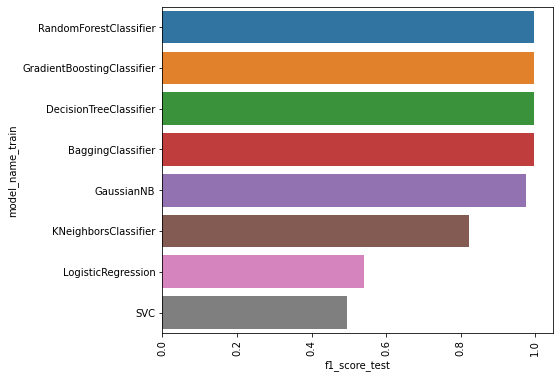

In [146]:
plt.figure(figsize=(7,6))
sns.barplot(y=summary['model_name_train'],x=summary['f1_score_test'])
plt.xticks(rotation=90)
plt.show()

In [147]:
#model creation
#model initialization
high_priority_model=GradientBoostingClassifier()

#fitting the model
high_priority_model.fit(X_train,y_train)

#predicting using the model
high_priority_pred=high_priority_model.predict(X_test)


#printing the confusion metrics and classification report
print('metrics on test data')
print('confusion matrix')
print(confusion_matrix(y_test,high_priority_pred))
print('\n')
print('classification report')
print(classification_report(y_test,high_priority_pred))
print('==='*10)

metrics on test data
confusion matrix
[[13772     0]
 [    2   208]]


classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13772
           1       1.00      0.99      1.00       210

    accuracy                           1.00     13982
   macro avg       1.00      1.00      1.00     13982
weighted avg       1.00      1.00      1.00     13982



In [148]:
# Save the model
with open('high_priority_model.pkl', 'wb') as file:
    pickle.dump(high_priority_model, file)


In [149]:
data_1=df.copy()

In [150]:
data_1.head()

,CI_Cat,CI_Subcat,WBS,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,No_of_Reassignments,Open_Time,Resolved_Time,Close_Time,No_of_Related_Interactions,Handle_Time_hrs_conv
0,11,57,162,0,4,4,4,0.601292,1,553,26,2012-05-02 13:32:00,2013-04-11 13:50:00,2013-04-11 13:51:00,1,8256.316667
1,1,57,88,0,3,3,3,0.415050,1,611,33,2012-12-03 15:44:00,2013-02-12 12:36:00,2013-02-12 12:36:00,1,1700.866667
2,1,10,92,0,4,3,4,0.517551,3,339,3,2012-03-29 12:36:00,2014-01-13 15:12:00,2014-01-13 15:13:00,1,15722.616667
3,1,57,88,0,4,4,4,0.642927,1,611,13,2012-07-17 11:49:00,2013-11-14 09:31:00,2013-11-14 09:31:00,1,11637.700000
4,1,57,88,0,4,4,4,0.345258,1,611,2,2012-10-08 11:01:00,2013-08-11 13:55:00,2013-08-11 13:55:00,1,7370.900000


In [151]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46606 entries, 0 to 46605
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   CI_Cat                      46606 non-null  int32         
 1   CI_Subcat                   46606 non-null  int32         
 2   WBS                         46606 non-null  int32         
 3   Status                      46606 non-null  int32         
 4   Impact                      46606 non-null  int32         
 5   Urgency                     46606 non-null  object        
 6   Priority                    46606 non-null  int32         
 7   number_cnt                  46606 non-null  float64       
 8   Category                    46606 non-null  int32         
 9   KB_number                   46606 non-null  int32         
 10  No_of_Reassignments         46606 non-null  int32         
 11  Open_Time                   46606 non-null  datetime64

In [152]:
#sorting the data based on the ticket opening time


In [153]:
timeseries_data=data_1.sort_values('Open_Time')

In [154]:
timeseries_data.head()

,CI_Cat,CI_Subcat,WBS,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,No_of_Reassignments,Open_Time,Resolved_Time,Close_Time,No_of_Related_Interactions,Handle_Time_hrs_conv
11,1,57,88,0,4,4,4,0.291928,1,611,8,2012-01-10 10:49:00,2013-08-11 14:18:00,2013-08-11 14:22:00,1,13899.550000
12,1,57,55,0,4,4,4,0.776486,1,401,5,2012-02-10 12:12:00,2014-04-02 09:38:00,2014-04-02 09:38:00,2,18765.433333
9,1,57,55,0,4,4,4,0.306670,1,401,2,2012-03-09 16:04:00,2013-08-11 14:33:00,2013-08-11 14:35:00,1,12478.516667
2,1,10,92,0,4,3,4,0.517551,3,339,3,2012-03-29 12:36:00,2014-01-13 15:12:00,2014-01-13 15:13:00,1,15722.616667
0,11,57,162,0,4,4,4,0.601292,1,553,26,2012-05-02 13:32:00,2013-04-11 13:50:00,2013-04-11 13:51:00,1,8256.316667


In [155]:
forecast_data=timeseries_data[['CI_Cat','Open_Time']]

In [156]:
forecast_data['Open_Time']=forecast_data['Open_Time'].dt.date

In [157]:
forecast_data.head()

,CI_Cat,Open_Time
11,1,2012-01-10
12,1,2012-02-10
9,1,2012-03-09
2,1,2012-03-29
0,11,2012-05-02


In [158]:
pivot_table=forecast_data.pivot_table(index='Open_Time',columns='CI_Cat',aggfunc='size')

In [159]:
pd.set_option('display.max_rows',None)

In [160]:
pivot_table

CI_Cat,0,1,2,3,4,5,6,7,8,9,10,11
Open_Time,,,,,,,,,,,,
2012-01-10,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-02-10,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-03-09,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-03-29,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-05-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2012-05-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2012-07-12,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-07-17,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-08-15,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [161]:
#converting the pivot table to dataframe

In [162]:
final_df=pd.DataFrame(pivot_table)

In [163]:
 #converting the index format from object type to datetime format

In [164]:
final_df.index=pd.to_datetime(final_df.index)

In [165]:
#filling the null values with 0

In [166]:
final_df.fillna(0,inplace=True)

In [167]:
len(final_df)

331

In [168]:
daily_data=final_df.resample('D',closed='right',label='right').asfreq()

In [169]:
quaterly_data=daily_data.resample('Q').sum()

In [170]:
quaterly_data

CI_Cat,0,1,2,3,4,5,6,7,8,9,10,11
Open_Time,,,,,,,,,,,,
2012-03-31,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2012-09-30,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-12-31,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2013-03-31,0.0,1751.0,0.0,206.0,4.0,8.0,21.0,6.0,5.0,21.0,31.0,408.0
2013-06-30,0.0,2044.0,2.0,215.0,4.0,20.0,12.0,5.0,14.0,17.0,51.0,433.0
2013-09-30,0.0,2363.0,0.0,267.0,7.0,17.0,16.0,7.0,9.0,13.0,27.0,449.0
2013-12-31,1.0,11496.0,3.0,1392.0,38.0,75.0,90.0,40.0,63.0,102.0,220.0,2633.0
2014-03-31,1.0,10539.0,0.0,1052.0,104.0,61.0,162.0,27.0,42.0,122.0,255.0,2671.0


In [171]:
quaterly_data.shape

(12, 12)

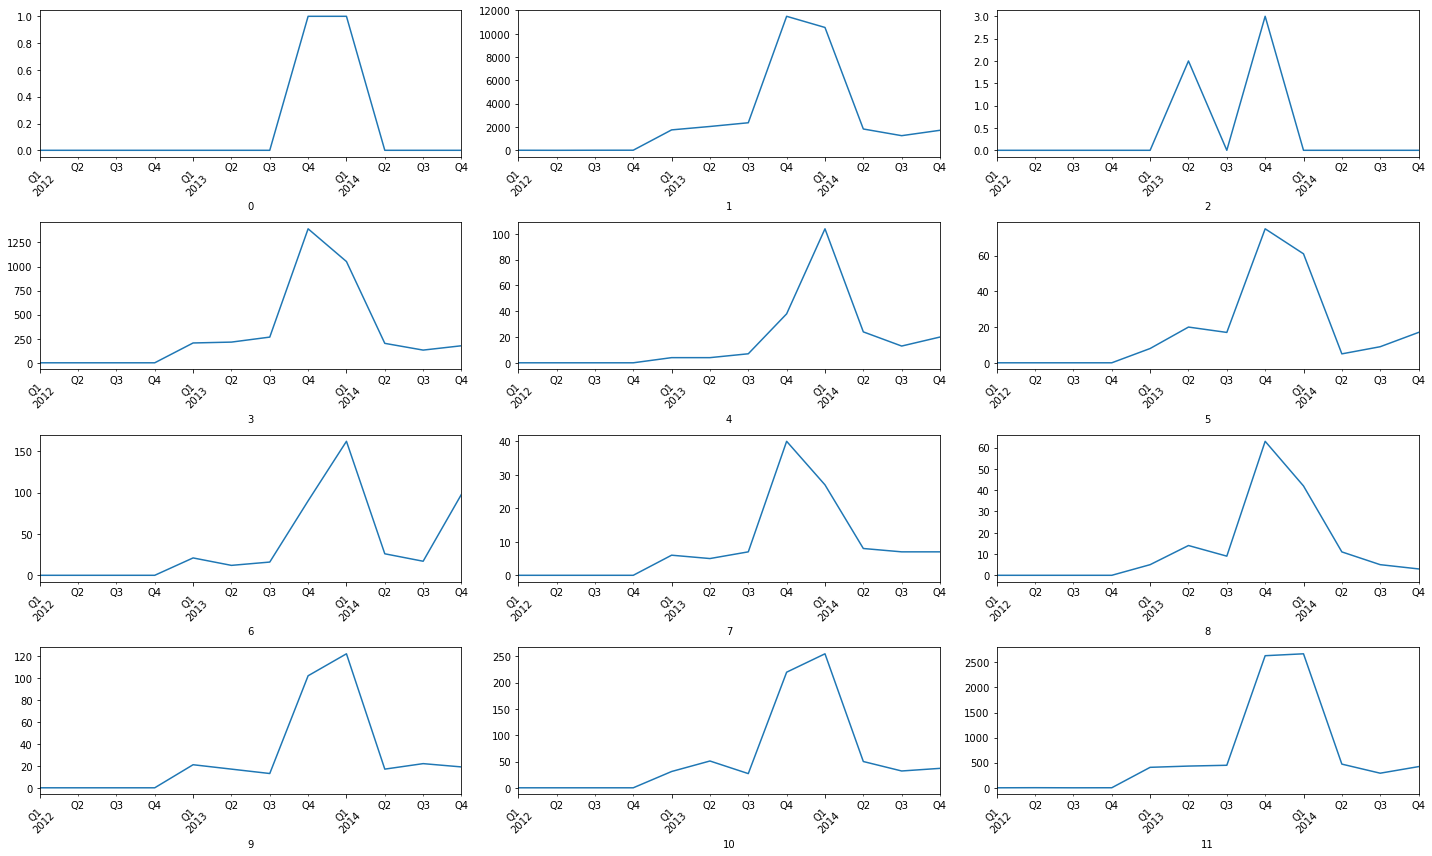

In [172]:
plt.figure(figsize=(20,12))
pl_no=1
for i in quaterly_data.columns:
    plt.subplot(4,3,pl_no)
    quaterly_data[i].plot()
    plt.xlabel(i)
    plt.xticks(rotation=45)
    pl_no+=1
plt.tight_layout()

In [173]:
#Arima model
#arima model forecasts and forecast plots

In [174]:
#perform the forecasting for each column
arima_forecast=pd.DataFrame()
steps=12
for column in quaterly_data.columns:
    model = ARIMA(quaterly_data[column],order=(1,0,0))
    model_fit=model.fit()
    forecast=model_fit.forecast(steps=steps)
    arima_forecast[column]=forecast

In [175]:
arima_forecast=arima_forecast.astype(int)

In [176]:
arima_forecast

,0,1,2,3,4,5,6,7,8,9,10,11
2015-03-31,0,2249,0,229,18,16,57,7,7,22,46,510
2015-06-30,0,2507,0,253,17,16,44,7,9,24,50,553
2015-09-30,0,2632,0,265,17,16,39,8,10,25,52,573
2015-12-31,0,2693,0,270,17,16,38,8,11,25,52,582
2016-03-31,0,2723,0,273,17,16,37,8,11,25,53,587
2016-06-30,0,2737,0,274,17,16,37,8,11,25,53,589
2016-09-30,0,2744,0,275,17,16,37,8,11,25,53,590
2016-12-31,0,2747,0,275,17,16,37,8,11,25,53,590
2017-03-31,0,2749,0,275,17,16,37,8,11,25,53,591
2017-06-30,0,2750,0,275,17,16,37,8,11,25,53,591


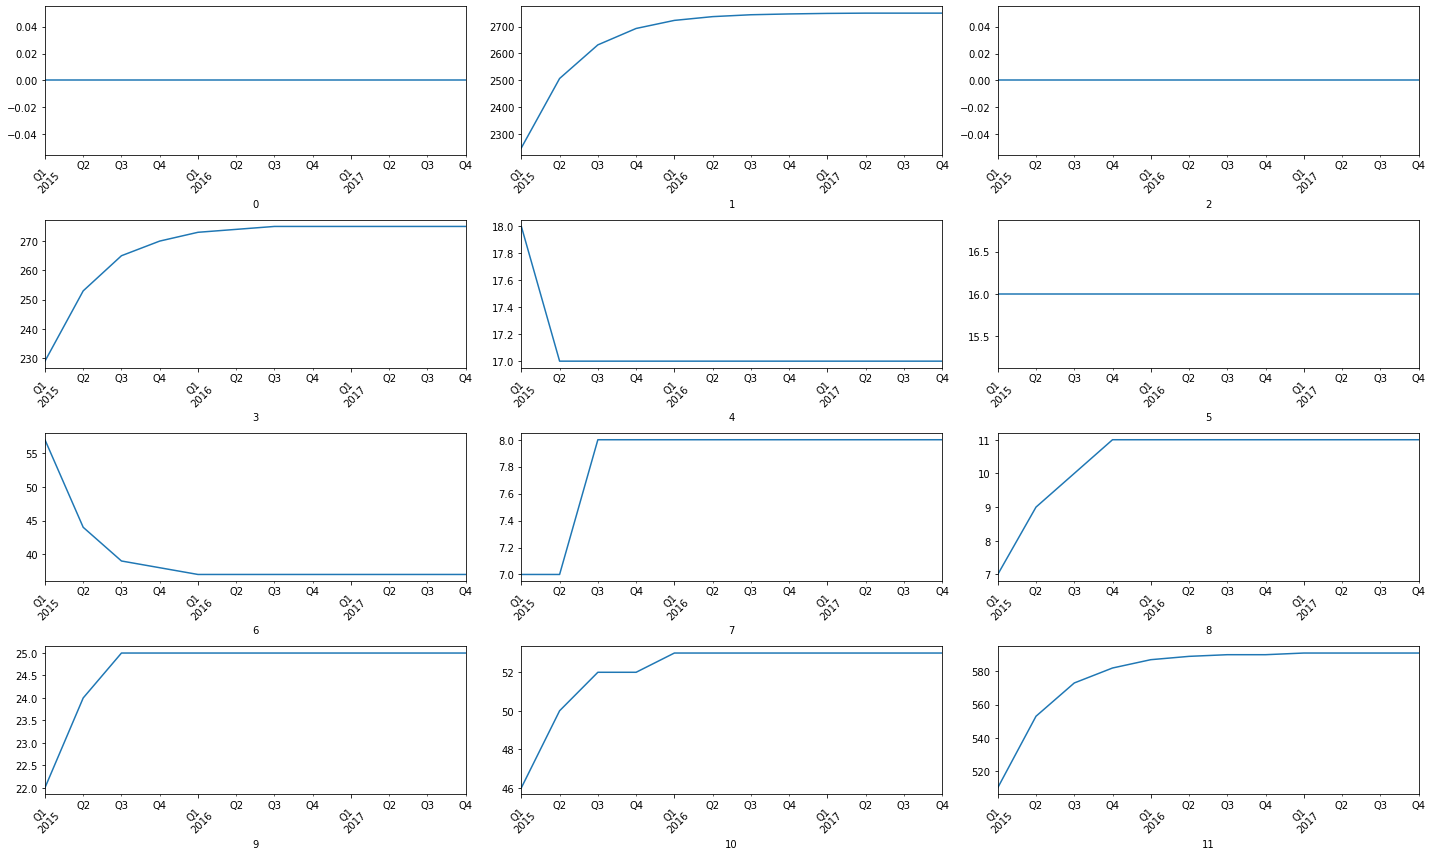

In [177]:
plt.figure(figsize=(20,12))
pl_no=1
for i in arima_forecast.columns:
    plt.subplot(4,3,pl_no)
    arima_forecast[i].plot()
    plt.xlabel(i)
    plt.xticks(rotation=45)
    pl_no+=1
plt.tight_layout()

In [178]:
#Sarimax model
columns_to_forecast=quaterly_data.columns
sarima_forecast=pd.DataFrame(columns=columns_to_forecast)
for column in columns_to_forecast:
    model= SARIMAX(quaterly_data[column],order=(1,0,0),seasonal_order=(1,0,0,12))
    model_fit=model.fit()
    forecast=model_fit.forecast(steps=12)
    sarima_forecast[column]=forecast

C:\Users\PREETHI\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\PREETHI\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\PREETHI\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\PREETHI\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\PREETHI\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarni

In [179]:
sarima_forecast=sarima_forecast.astype(int)

In [180]:
sarima_forecast

CI_Cat,0,1,2,3,4,5,6,7,8,9,10,11
2015-03-31,0,1097,0,3,0,0,55,0,0,0,0,11
2015-06-30,0,701,0,2,0,0,31,0,0,0,0,6
2015-09-30,0,448,0,1,0,0,18,0,0,0,0,5
2015-12-31,0,286,0,1,0,0,10,0,0,0,0,2
2016-03-31,0,169,0,-203,-3,-7,5,-5,-4,-20,-30,-400
2016-06-30,0,101,0,-212,-3,-19,3,-4,-13,-16,-50,-426
2016-09-30,0,56,0,-264,-6,-16,1,-6,-8,-12,-26,-442
2016-12-31,0,-40,0,-1380,-37,-74,0,-39,-62,-101,-218,-2601
2017-03-31,0,-50,0,-1043,-102,-60,0,-26,-41,-121,-252,-2639
2017-06-30,0,5,0,-200,-23,-4,0,-7,-10,-16,-49,-466


In [181]:
data_3=df.copy()

In [182]:
data_3.head()

,CI_Cat,CI_Subcat,WBS,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,No_of_Reassignments,Open_Time,Resolved_Time,Close_Time,No_of_Related_Interactions,Handle_Time_hrs_conv
0,11,57,162,0,4,4,4,0.601292,1,553,26,2012-05-02 13:32:00,2013-04-11 13:50:00,2013-04-11 13:51:00,1,8256.316667
1,1,57,88,0,3,3,3,0.415050,1,611,33,2012-12-03 15:44:00,2013-02-12 12:36:00,2013-02-12 12:36:00,1,1700.866667
2,1,10,92,0,4,3,4,0.517551,3,339,3,2012-03-29 12:36:00,2014-01-13 15:12:00,2014-01-13 15:13:00,1,15722.616667
3,1,57,88,0,4,4,4,0.642927,1,611,13,2012-07-17 11:49:00,2013-11-14 09:31:00,2013-11-14 09:31:00,1,11637.700000
4,1,57,88,0,4,4,4,0.345258,1,611,2,2012-10-08 11:01:00,2013-08-11 13:55:00,2013-08-11 13:55:00,1,7370.900000


In [183]:
data_3=data_3.drop(['Open_Time','Resolved_Time','Close_Time'],axis=1)

In [184]:
X1=data_3.drop(['Priority','CI_Cat','Urgency'],axis=1)

In [185]:
X1.head()

,CI_Subcat,WBS,Status,Impact,number_cnt,Category,KB_number,No_of_Reassignments,No_of_Related_Interactions,Handle_Time_hrs_conv
0,57,162,0,4,0.601292,1,553,26,1,8256.316667
1,57,88,0,3,0.415050,1,611,33,1,1700.866667
2,10,92,0,4,0.517551,3,339,3,1,15722.616667
3,57,88,0,4,0.642927,1,611,13,1,11637.700000
4,57,88,0,4,0.345258,1,611,2,1,7370.900000


In [186]:
y1=data_3['Priority']

In [187]:
y1.head()

0    4
1    3
2    4
3    4
4    4
Name: Priority, dtype: int32

In [188]:
y2=data_3['CI_Cat']

In [189]:
model_summary_1={'model_name_train':[],'f1_score_train':[],'recall_score_train':[],'accuracy_score_train':[],
               'model_name_test':[],'f1_score_test':[],'recall_score_test':[],'accuracy_score_test':[]}


def model_selction_2(model):

    #model initialization ,fitting and predicting
    print(model)
    model=model()
    model.fit(X_train,y_train)
    model_pred=model.predict(X_test)

    #appending the metrics to the dictionary created
    model_summary_1['model_name_test'].append(model.__class__.__name__)
    model_summary_1['f1_score_test'].append(f1_score(y_test,model_pred,average='macro'))
    model_summary_1['recall_score_test'].append(recall_score(y_test,model_pred,average='macro'))
    model_summary_1['accuracy_score_test'].append(accuracy_score(y_test,model_pred))

    #printing the confusion metrics and classification report
    print('metrics on test data')
    print(confusion_matrix(y_test,model_pred))
    print('\n')
    print(classification_report(y_test,model_pred))

    #predictions on train data
    model_pred1=model.predict(X_train)

    #appending the metrics to the dictionary created
    model_summary_1['model_name_train'].append(model.__class__.__name__)
    model_summary_1['f1_score_train'].append(f1_score(y_train,model_pred1,average='macro'))
    model_summary_1['recall_score_train'].append(recall_score(y_train,model_pred1,average='macro'))
    model_summary_1['accuracy_score_train'].append(accuracy_score(y_train,model_pred1))

    #printing the confusion metrics and classification report
    print('metrics on train data')
    print(confusion_matrix(y_train,model_pred1))
    print('\n')
    print(classification_report(y_train,model_pred1))
    print('==='*10)

In [190]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.3, random_state=42,stratify=y1)

In [191]:
for i in models:
    model_selction_2(i)

<class 'sklearn.linear_model._logistic.LogisticRegression'>
metrics on test data
[[   0    0    0    1    0]
 [   0    0    0   65  144]
 [   0    0    0 1283  314]
 [   0    0    0 6189 1040]
 [   0    0    0 4243  703]]


              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00       209
           3       0.00      0.00      0.00      1597
           4       0.53      0.86      0.65      7229
           5       0.32      0.14      0.20      4946

    accuracy                           0.49     13982
   macro avg       0.17      0.20      0.17     13982
weighted avg       0.38      0.49      0.41     13982

metrics on train data
[[    0     0     0     1     1]
 [    0     0     0   155   333]
 [    0     0     0  3018   708]
 [    0     0     0 14441  2427]
 [    0     0     0  9901  1639]]


              precision    recall  f1-score   support

           1       0.00      0.00      0.0

In [192]:
summary_1=pd.DataFrame(model_summary_1).sort_values('f1_score_test',ascending=False).drop('model_name_test',axis=1)

In [193]:
summary_1

,model_name_train,f1_score_train,recall_score_train,accuracy_score_train,f1_score_test,recall_score_test,accuracy_score_test
7,GradientBoostingClassifier,0.997948,0.997478,0.997333,0.995006,0.993407,0.994922
3,BaggingClassifier,0.999568,0.999382,0.999663,0.994310,0.993643,0.995566
1,DecisionTreeClassifier,1.000000,1.000000,1.000000,0.991881,0.992242,0.993635
2,RandomForestClassifier,1.000000,1.000000,1.000000,0.794912,0.793332,0.995566
5,GaussianNB,0.991037,0.990445,0.991601,0.788099,0.787082,0.990917
4,KNeighborsClassifier,0.653240,0.644524,0.866111,0.588496,0.582294,0.801602
6,SVC,0.229602,0.247862,0.579144,0.230974,0.249040,0.580675
0,LogisticRegression,0.169526,0.199629,0.492889,0.169571,0.199654,0.492919


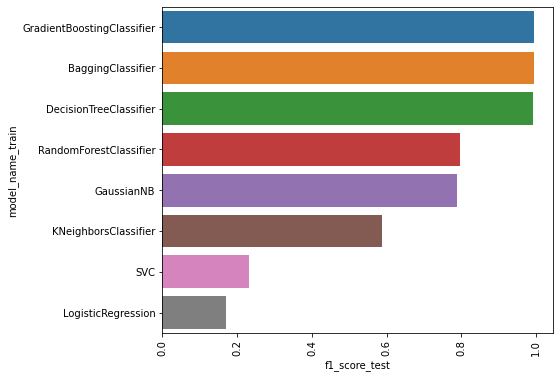

In [194]:
plt.figure(figsize=(7,6))
sns.barplot(y=summary_1['model_name_train'],x=summary_1['f1_score_test'])
plt.xticks(rotation=90)
plt.show()

In [195]:
#model creation
#model initialization
all_priority_model=GradientBoostingClassifier()

#fitting the model
all_priority_model.fit(X_train,y_train)

#predicting using the model
all_priority_pred=all_priority_model.predict(X_test)

#printing the confusion metrics and classification report
print('metrics on test data')
print('confusion matrix')
print(confusion_matrix(y_test,all_priority_pred))
print('\n')
print('classification report')
print(classification_report(y_test,all_priority_pred))
print('==='*10)

metrics on test data
confusion matrix
[[   1    0    0    0    0]
 [   0  207    2    0    0]
 [   0    0 1569   26    2]
 [   0    0    7 7191   31]
 [   0    0    1    2 4943]]


classification report
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1
           2       1.00      0.99      1.00       209
           3       0.99      0.98      0.99      1597
           4       1.00      0.99      1.00      7229
           5       0.99      1.00      1.00      4946

    accuracy                           0.99     13982
   macro avg       1.00      0.99      1.00     13982
weighted avg       0.99      0.99      0.99     13982



In [196]:
# Save the model
with open('all_priority_model.pkl', 'wb') as file:
    pickle.dump(all_priority_model, file)


In [197]:
model_summary_3={'model_name_train':[],'f1_score_train':[],'recall_score_train':[],'accuracy_score_train':[],
               'model_name_test':[],'f1_score_test':[],'recall_score_test':[],'accuracy_score_test':[]}


def model_selction_3(model):

    #model initialization ,fitting and predicting
    print(model)
    model=model()
    model.fit(X_train,y_train)
    model_pred=model.predict(X_test)

    #appending the metrics to the dictionary created
    model_summary_3['model_name_test'].append(model.__class__.__name__)
    model_summary_3['f1_score_test'].append(f1_score(y_test,model_pred,average='macro'))
    model_summary_3['recall_score_test'].append(recall_score(y_test,model_pred,average='macro'))
    model_summary_3['accuracy_score_test'].append(accuracy_score(y_test,model_pred))

    #printing the confusion metrics and classification report
    print('metrics on test data')
    print(confusion_matrix(y_test,model_pred))
    print('\n')
    print(classification_report(y_test,model_pred))

    #predictions on train data
    model_pred1=model.predict(X_train)

    #appending the metrics to the dictionary created
    model_summary_3['model_name_train'].append(model.__class__.__name__)
    model_summary_3['f1_score_train'].append(f1_score(y_train,model_pred1,average='macro'))
    model_summary_3['recall_score_train'].append(recall_score(y_train,model_pred1,average='macro'))
    model_summary_3['accuracy_score_train'].append(accuracy_score(y_train,model_pred1))

    #printing the confusion metrics and classification report
    print('metrics on train data')
    print(confusion_matrix(y_train,model_pred1))
    print('\n')
    print(classification_report(y_train,model_pred1))
    print('==='*10)

In [198]:
X_train, X_test, y_train, y_test = train_test_split(X1, y2, test_size=0.3, random_state=42,stratify=y2)

In [199]:
for i in models:
    model_selction_3(i)

<class 'sklearn.linear_model._logistic.LogisticRegression'>
metrics on test data
[[8969    0  318    0    0    0    0    0    0    1  615]
 [   1    0    0    0    0    0    0    0    0    0    0]
 [1003    0   88    0    0    0    0    0    0    0    2]
 [  61    0    3    0    0    0    0    0    0    0    0]
 [  64    0    0    0    0    0    0    0    0    0    0]
 [ 102    0   31    0    0    0    0    0    0    0    0]
 [  32    0    0    0    0    0    0    0    0    0    0]
 [  46    0    0    0    0    0    0    0    0    0    0]
 [  80    0   20    0    0    0    0    0    0    0    0]
 [ 209    0    2    0    0    0    0    0    0    0    0]
 [2248    0   28    0    0    0    0    0    0    0   59]]


              precision    recall  f1-score   support

           1       0.70      0.91      0.79      9903
           2       0.00      0.00      0.00         1
           3       0.18      0.08      0.11      1093
           4       0.00      0.00      0.00        64
       

In [200]:
summary_3=pd.DataFrame(model_summary_3).sort_values('f1_score_test',ascending=False).drop('model_name_test',axis=1)

In [201]:
summary_3

,model_name_train,f1_score_train,recall_score_train,accuracy_score_train,f1_score_test,recall_score_test,accuracy_score_test
3,BaggingClassifier,0.999131,0.998485,0.999019,0.900809,0.895826,0.991847
1,DecisionTreeClassifier,1.000000,1.000000,1.000000,0.900181,0.898181,0.989916
7,GradientBoostingClassifier,0.991746,0.989563,0.974191,0.893686,0.882197,0.973609
2,RandomForestClassifier,0.999991,0.999985,0.999969,0.872761,0.857171,0.978758
4,KNeighborsClassifier,0.688693,0.646764,0.939400,0.688016,0.649923,0.914962
5,GaussianNB,0.477070,0.671128,0.540001,0.434034,0.645880,0.545773
0,LogisticRegression,0.079082,0.084684,0.651606,0.085451,0.091951,0.651981
6,SVC,0.069168,0.083364,0.708374,0.075379,0.090900,0.708196


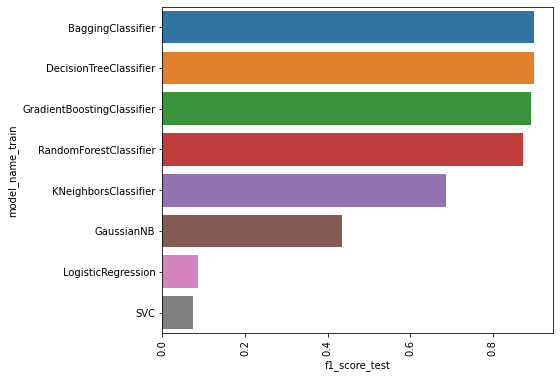

In [202]:
plt.figure(figsize=(7,6))
sns.barplot(y=summary_3['model_name_train'],x=summary_3['f1_score_test'])
plt.xticks(rotation=90)
plt.show()

In [203]:
#model creation
#model initialization
department_classification_model=RandomForestClassifier()

#fitting the model
department_classification_model.fit(X_train,y_train)

#predicting using the model
department_classification_pred=department_classification_model.predict(X_test)

#printing the confusion metrics and classification report
print('metrics on test data')
print('confusion matrix')
print(confusion_matrix(y_test,department_classification_pred))
print('\n')
print('classification report')
print(classification_report(y_test,department_classification_pred))
print('==='*10)

metrics on test data
confusion matrix
[[9815    0    0    0    0    0    0    0    0    0   88]
 [   0    1    0    0    0    0    0    0    0    0    0]
 [   8    0 1085    0    0    0    0    0    0    0    0]
 [   0    0    0   63    0    0    1    0    0    0    0]
 [   0    0    0    0   64    0    0    0    0    0    0]
 [   2    0    3    0    0  128    0    0    0    0    0]
 [   7    0    4    0    1    1   18    0    1    0    0]
 [   0    0    0    0    0    0    0   46    0    0    0]
 [   1    0    0    0    0    0    0    0   99    0    0]
 [   1    0    1    0    0    2    0    0    0  207    0]
 [ 172    0    0    0    0    0    0    0    0    0 2163]]


classification report
              precision    recall  f1-score   support

           1       0.98      0.99      0.99      9903
           2       1.00      1.00      1.00         1
           3       0.99      0.99      0.99      1093
           4       1.00      0.98      0.99        64
           5       0.98     

In [204]:
# Save the model
with open('department_classification_model.pkl', 'wb') as file:
    pickle.dump(department_classification_model, file)
